In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-notebook')

%matplotlib inline
ohe = OneHotEncoder(drop="first", sparse=False)

In [3]:
orig_data = pd.read_csv('../data/kc_house_data.csv', index_col=0)
df = orig_data.copy()

In [4]:
#remove extra columns
df = df.drop(df[['date', 'view', 'sqft_lot', 'sqft_above', 'nuisance','greenbelt','floors','sqft_garage','sqft_patio', 'sqft_basement', 'lat', 'long' ]], axis = 1)
# df = df['heat_source'].notna()
# df.isnull().sum()

In [5]:
df['Age'] = 2022- df['yr_built'].astype(int)
grade_num = []
for index, row in df.iterrows():
    grade_num.append(int((str(row['grade'])[0:2])))
df['grade_num'] = grade_num
df.drop('grade', axis = 1)
df['heat_num'] = df['heat_source'].replace({'Gas': 1, 'Electricity' : 2, 'Oil': 3, 'Gas/Solar': 4, 'Electricity/Solar':5, 'Oil/Solar':6, 'Other':7 })
df['condition_num'] = df['condition'].replace({'Poor': 1, 'Fair' : 2, 'Average': 3, 'Good': 4, 'Very Good':5 })
# df.drop('condition', axis = 1)
df.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,heat_source,sewer_system,yr_built,yr_renovated,address,Age,grade_num,heat_num,condition_num
id,,,,,,,,,,,,,,,,
7399300360,675000.0,4,1.0,1180,NO,Good,7 Average,Gas,PUBLIC,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",53,7,1.0,4
8910500230,920000.0,5,2.5,2770,NO,Average,7 Average,Oil,PUBLIC,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",72,7,3.0,3
1180000275,311000.0,6,2.0,2880,NO,Average,7 Average,Gas,PUBLIC,1956,0,"8504 South 113th Street, Seattle, Washington 9...",66,7,1.0,3
1604601802,775000.0,3,3.0,2160,NO,Average,9 Better,Gas,PUBLIC,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",12,9,1.0,3
8562780790,592500.0,2,2.0,1120,NO,Average,7 Average,Electricity,PUBLIC,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",10,7,2.0,3


In [6]:
#Added column to show whether or not house was renovated, and if so how long ago
# df['Renovation(y/n)'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
# df['Renovation_Age'] = df['yr_renovated'].apply(lambda x: 2022-x if x > 0 else 0)



In [7]:
historic = df[df['yr_built'] < 1972]
historic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13498 entries, 7399300360 to 9557800100
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          13498 non-null  float64
 1   bedrooms       13498 non-null  int64  
 2   bathrooms      13498 non-null  float64
 3   sqft_living    13498 non-null  int64  
 4   waterfront     13498 non-null  object 
 5   condition      13498 non-null  object 
 6   grade          13498 non-null  object 
 7   heat_source    13476 non-null  object 
 8   sewer_system   13496 non-null  object 
 9   yr_built       13498 non-null  int64  
 10  yr_renovated   13498 non-null  int64  
 11  address        13498 non-null  object 
 12  Age            13498 non-null  int32  
 13  grade_num      13498 non-null  int64  
 14  heat_num       13476 non-null  float64
 15  condition_num  13498 non-null  int64  
dtypes: float64(3), int32(1), int64(6), object(6)
memory usage: 1.7+ MB


In [8]:
historic['Renovation'] = historic['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
historic['Renovation_Age'] = historic['yr_renovated'].apply(lambda x: 2022-x if x > 0 else 0)

<ipython-input-8-83aae6da00d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['Renovation'] = historic['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
<ipython-input-8-83aae6da00d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['Renovation_Age'] = historic['yr_renovated'].apply(lambda x: 2022-x if x > 0 else 0)


# BUILDING CONDITION

	Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

# BUILDING GRADE

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

In [9]:
# df.corr()['price']
# df_test = df[df[['price', 'sqft_living', ]]]
# df_test.head()


In [10]:
historic_corr = historic.corr()['price'].map(abs).sort_values(ascending=False)
historic_corr

price             1.000000
sqft_living       0.546045
grade_num         0.543023
bathrooms         0.448653
bedrooms          0.246299
yr_renovated      0.173996
Renovation        0.173569
Renovation_Age    0.109299
heat_num          0.084620
Age               0.075811
yr_built          0.075811
condition_num     0.067956
Name: price, dtype: float64

In [11]:
historic_pred1 = historic[['grade_num']]
target = historic['price']
historic_with_con = sm.add_constant(historic_pred1)

In [12]:
historic['address']

id
7399300360    2102 Southeast 21st Court, Renton, Washington ...
8910500230    11231 Greenwood Avenue North, Seattle, Washing...
1180000275    8504 South 113th Street, Seattle, Washington 9...
2807100156    1602 North 185th Street, Shoreline, Washington...
5122400111    2633 Southwest 164th Place, Burien, Washington...
                                    ...                        
8081900170    3303 Northwest 72nd Street, Seattle, Washingto...
3277800805    6324 34th Avenue Southwest, Seattle, Washingto...
3915500105    407 M Street Southeast, Auburn, Washington 980...
7834800180    4673 Eastern Avenue North, Seattle, Washington...
9557800100    18615 7th Avenue South, Burien, Washington 981...
Name: address, Length: 13498, dtype: object

In [13]:
model1 = sm.OLS(endog=target, exog=historic_pred1).fit()
model1.rsquared
#Grade accounts for 68% of variation in price

0.6844297712201564

In [14]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.684
Model:                            OLS   Adj. R-squared (uncentered):              0.684
Method:                 Least Squares   F-statistic:                          2.927e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):                        0.00
Time:                        14:41:28   Log-Likelihood:                     -2.0104e+05
No. Observations:               13498   AIC:                                  4.021e+05
Df Residuals:                   13497   BIC:                                  4.021e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade_num   1.475e+05    862.182    171.094      0.000    1.46e+05    1.49e+05
==============================================================================
Omnibus:                    17250.191   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5601571.107
Skew:                           6.848   Prob(JB):                         0.00
Kurtosis:                     101.855   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# y_scld = np.log(target)
# y_scld.hist() 

<AxesSubplot:>

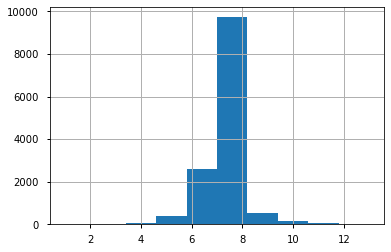

In [16]:
historic['grade_num'].hist()

<AxesSubplot:>

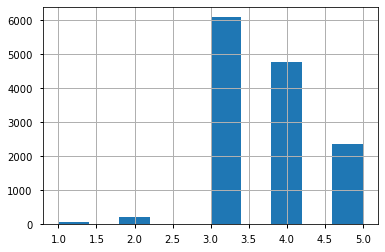

In [17]:
historic['condition_num'].hist()

In [18]:
historic_pred2 = historic[['sqft_living', 'grade_num',]]
historic_with_con2 = sm.add_constant(historic_pred2)
model2 = sm.OLS(endog=target, exog=historic_pred2).fit()
model2.rsquared
# SQ_ft living and Grade accounts for 68% of variation in price
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.739
Model:                            OLS   Adj. R-squared (uncentered):              0.739
Method:                 Least Squares   F-statistic:                          1.915e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):                        0.00
Time:                        14:41:29   Log-Likelihood:                     -1.9975e+05
No. Observations:               13498   AIC:                                  3.995e+05
Df Residuals:                   13496   BIC:                                  3.995e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   456.2206      8.546     53.382      0.000     439.469     472.973
grade_num     2.91e+04   2352.523     12.370      0.000    2.45e+04    3.37e+04
==============================================================================
Omnibus:                    17580.559   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6969397.944
Skew:                           7.022   Prob(JB):                         0.00
Kurtosis:                     113.429   Cond. No.                         827.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
historic_pred3 = historic[['grade_num', 'condition_num', 'Age']]
historic_with_con3 = sm.add_constant(historic_pred3)
model3 = sm.OLS(endog=target, exog=historic_pred3).fit()
model3.rsquared
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.694
Model:                            OLS   Adj. R-squared (uncentered):              0.694
Method:                 Least Squares   F-statistic:                          1.021e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):                        0.00
Time:                        14:41:29   Log-Likelihood:                     -2.0083e+05
No. Observations:               13498   AIC:                                  4.017e+05
Df Residuals:                   13495   BIC:                                  4.017e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
grade_num      2.297e+05   4165.524     55.136      0.000    2.22e+05    2.38e+05
condition_num -1.207e+05   6895.415    -17.505      0.000   -1.34e+05   -1.07e+05
Age           -1877.0157    272.230     -6.895      0.000   -2410.625   -1343.406
==============================================================================
Omnibus:                    16927.808   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5336464.931
Skew:                           6.609   Prob(JB):                         0.00
Kurtosis:                      99.508   Cond. No.                         100.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
historic_pred3_scld = (historic_pred3 - historic_pred3.mean()) / historic_pred3.std(ddof=0)
ss = StandardScaler()
ss.fit(historic_pred3)
historic_pred3_scld1 = ss.transform(historic_pred3)
historic_pred3_scld1
np.allclose(historic_pred3_scld1, historic_pred3_scld)
historic_pred3_scld.head()

,grade_num,condition_num,Age
id,,,
7399300360,-0.045835,0.404192,-1.223950
8910500230,-0.045835,-0.859014,-0.244257
1180000275,-0.045835,-0.859014,-0.553634
2807100156,-0.045835,-0.859014,-0.141131
5122400111,2.098657,0.404192,-0.295820


In [21]:
lr = LinearRegression()
lr.fit(historic_pred3_scld, target)

LinearRegression()

In [22]:
lr.coef_

array([428967.73700534,  25010.2424647 , 100877.04234739])

In [23]:
lr.intercept_

1001332.7615202252

In [24]:
lr.score(historic_pred3_scld, target)

0.31228217654502144

In [25]:
y_hat = lr.predict(historic_pred3_scld)
y_hat

array([ 868311.32985235,  935546.81229239,  904337.78726954, ...,
        522785.44587508, 1577942.50576293,  857524.24973525])

In [26]:
residual = (target - y_hat)

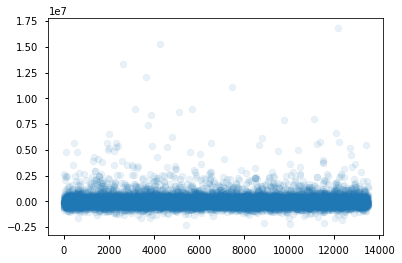

In [27]:
fig, ax = plt.subplots()
ax.scatter(x=range(y_hat.shape[0]),y=residual, alpha=0.1);

In [28]:
metrics.r2_score(target, lr.predict(historic_pred3_scld))
#R squared

0.31228217654502144

In [29]:
test_target_mean = np.mean(target)
qty = len(target)

In [30]:
metrics.r2_score(target, test_target_mean * np.ones(qty))

0.0

In [31]:
metrics.mean_squared_error(target, lr.predict(historic_pred3_scld))

413975843711.4805

In [32]:
metrics.mean_absolute_error(target, lr.predict(historic_pred3_scld))

356879.16124599817

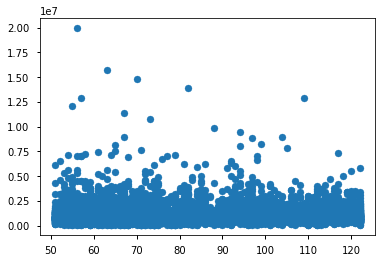

In [33]:
fig, ax = plt.subplots()
ax.scatter(historic['Age'], target)

In [34]:
cond_mean = historic.groupby('condition_num')['price'].mean()
cond_median = historic.groupby('condition_num')['price'].median()
grade_mean = historic.groupby('grade_num')['price'].mean()
grade_median =historic.groupby('grade_num')['price'].median()

cond_mean
cond_median
grade_mean
# grade_median

grade_num
1     1.352500e+06
2     2.050000e+05
3     4.644615e+05
4     6.434913e+05
5     6.168935e+05
6     6.565801e+05
7     8.759205e+05
8     1.345417e+06
9     2.165450e+06
10    3.026816e+06
11    4.785856e+06
12    6.757626e+06
13    7.569037e+06
Name: price, dtype: float64

<AxesSubplot:>

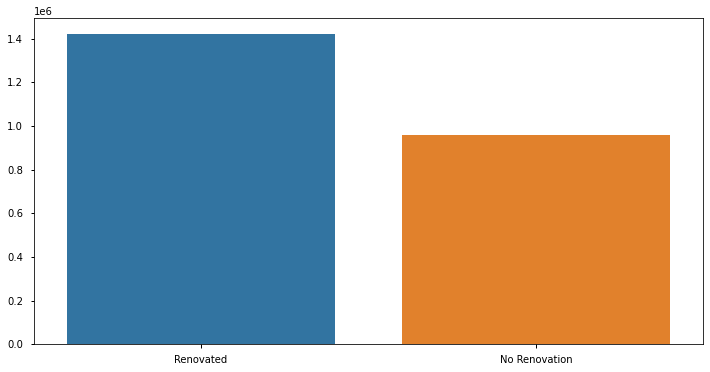

In [35]:
renovated = historic[(historic["Renovation"] == 1)]
renovated_mean = renovated.price.mean()
no_renovation = historic[(historic["Renovation"] == 0)]
no_renovation_mean = no_renovation.price.mean()

label_renovation = ["Renovated", "No Renovation"]
values_renovation = [renovated_mean, no_renovation_mean]

fig, ax = plt.subplots( figsize=(12,6))
sns.barplot(ax=ax, x=label_renovation, y=values_renovation)


In [36]:
stats.ttest_ind(renovated.price, no_renovation.price, equal_var=False)

Ttest_indResult(statistic=12.749401282812514, pvalue=3.304249081572757e-35)

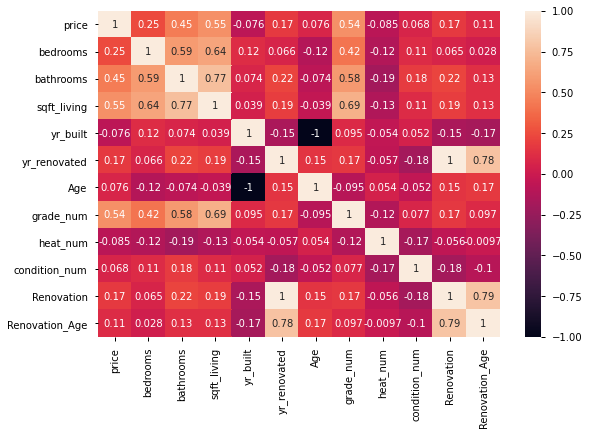

In [37]:
sns.heatmap(historic.corr(),annot=True)
fig=plt.gcf()
fig.set_size_inches(9,6)
plt.show()

In [38]:
X = df['grade_num']
y = df['price']

dummy_regr = DummyRegressor(strategy="mean")
print(dummy_regr.fit(X, y))

print(dummy_regr.predict(X))
print(dummy_regr.score(X, y))

DummyRegressor()
[1108535.837871 1108535.837871 1108535.837871 ... 1108535.837871
 1108535.837871 1108535.837871]
0.0


In [39]:
ohe = OneHotEncoder()
historic_1 = historic[['price', 'Age', 'grade_num', 'condition_num']]
ohe.fit(historic_1)

OneHotEncoder()

In [40]:
historic1_encoded = ohe.transform(historic_1)
historic1_encoded

<13498x2893 sparse matrix of type '<class 'numpy.float64'>'
	with 53992 stored elements in Compressed Sparse Row format>

In [41]:
X1 = historic.drop('price', axis=1)
y1 = historic['price']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=3)

In [42]:
dummy = DummyRegressor(strategy = 'mean')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

print(dummy.score(X_test, y_test))

#R squared

-1.6949133196941801e-06


In [43]:
error = dummy.predict(X_test)-y_test
er2=(error)*(error)
er2_mean=er2.mean()
er2_mean_er2= np.sqrt(er2_mean)
print(er2_mean_er2)

900053.5909677658


In [44]:
y1 = df['price']
x1 = df[['grade_num', 'Age', 'heat_source']]
x1

,grade_num,Age,heat_source
id,,,
7399300360,7,53,Gas
8910500230,7,72,Oil
1180000275,7,66,Gas
1604601802,9,12,Gas
8562780790,7,10,Electricity
...,...,...,...
7834800180,8,101,Oil
194000695,7,11,Gas
7960100080,7,27,Gas


In [45]:
x1 = pd.get_dummies(x1, columns=['heat_source'], drop_first=True)
x1

,grade_num,Age,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other
id,,,,,,,,
7399300360,7,53,0,1,0,0,0,0
8910500230,7,72,0,0,0,1,0,0
1180000275,7,66,0,1,0,0,0,0
1604601802,9,12,0,1,0,0,0,0
8562780790,7,10,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
7834800180,8,101,0,0,0,1,0,0
194000695,7,11,0,1,0,0,0,0
7960100080,7,27,0,1,0,0,0,0


In [46]:
dummymodel = sm.OLS(y1, sm.add_constant(x1))
dum_results = dummymodel.fit()

print(dum_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     2127.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:41:31   Log-Likelihood:            -4.4935e+05
No. Observations:               30155   AIC:                         8.987e+05
Df Residuals:                   30146   BIC:                         8.988e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

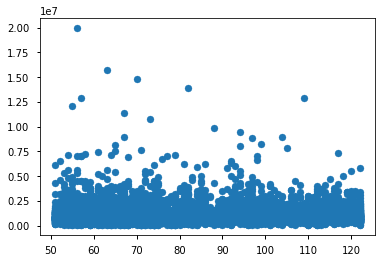

In [47]:
xx = historic['Age']
yy = historic['price']

fig, ax = plt.subplots()
ax.scatter(xx,yy)



<AxesSubplot:xlabel='grade_num', ylabel='price'>

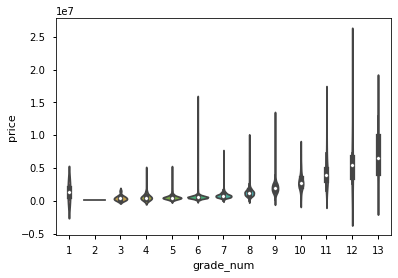

In [49]:
sns.violinplot(data=historic, x="grade_num", y=target)

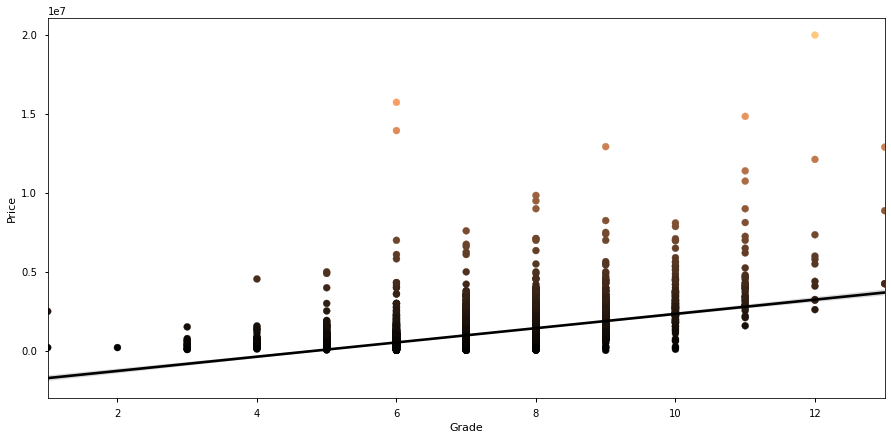

In [51]:
fig, ax = plt.subplots(figsize = (15,7))



ax = sns.regplot(x ='grade_num', y = 'price', data = historic, scatter = False, color = 'black');
ax.scatter(historic['grade_num'], historic['price'], c = historic['price'],  cmap="copper");

#ax.hlines(y=60.4, xmin=0, xmax=4e8, linewidth=2, color='cyan')
#ax.vlines(x=0.9e8, ymin=0, ymax=100, linewidth=2, color='cyan')
ax.set_ylabel('Price');
ax.set_xlabel('Grade');

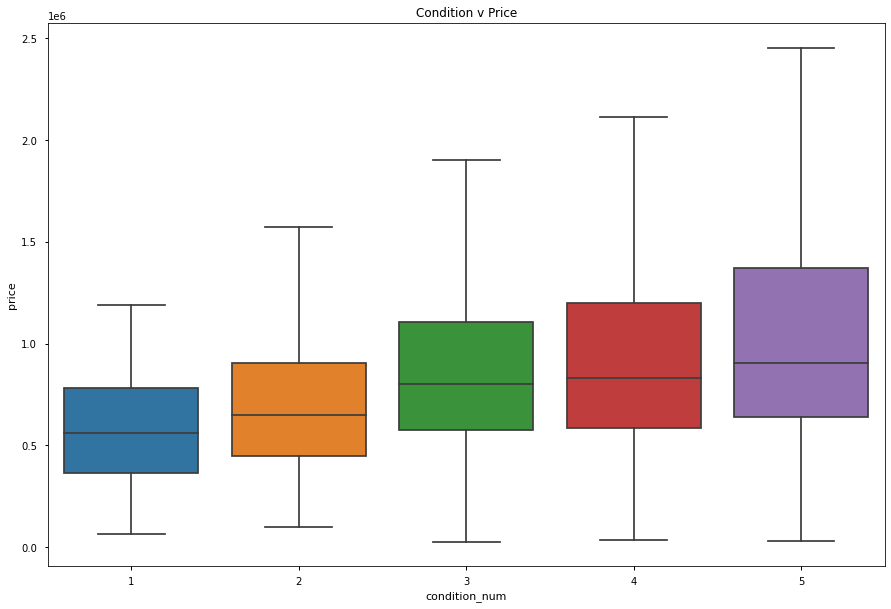

In [53]:
fig, ax = plt.subplots(figsize = (15,10))

ax = sns.boxplot(x = historic['condition_num'], y = historic['price'], showfliers = False)
ax.set_title("Condition v Price");
# ax.set_yticks(np.arange(-1,9));